In [37]:
import os
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss)  # in bytes 

722333696


In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

TRAFFIC_DIRECTION = 'sent'


np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [39]:
import requests
import json

# Fetch data from netdata
vim_endpoint = "131.234.250.178"
chart_id = "cgroup_kubepods_burstable_podbe0f3d0e-1991-4598-a93a-d04cd848da32_152a6c5a75fa37430be58a76e46b81cc85a33eefc.net_eth0"
# 7 days = 604800
avg_sec = 604800
group_time = 5
_c_name = chart_id.split(".")[1]

# http://vimdemo1.cs.upb.de:19999/api/v1/data?chart=cgroup_qemu_qemu_127_instance_0000007f.net_tap0c32c278_4e&gtime=60
_chart_avg_url = "http://{host}:19999/api/v1/data?chart={chart_id}&format=json&after=-{last_sec_avg}&gtime={gtime}&options=flip"

r = requests.get(_chart_avg_url.format(host=vim_endpoint, chart_id=chart_id, 
                                           last_sec_avg=avg_sec, gtime=group_time), verify=False)

_instance_metrics = {}

if r.status_code == requests.codes.ok:
    _result_json = json.loads(r.text)
    if "net" in _c_name:
        if "packets" in _c_name:
            _instance_metrics["packets"] = _result_json
        else:
            _instance_metrics["net"] = _result_json
    else:
        _instance_metrics[_c_name] = _result_json

# _result_json


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

train = pd.DataFrame(_result_json['data'], columns=_result_json['labels'])

train = train.set_index("time")



traffic_training_complete = train
traffic_training_processed_complete = traffic_training_complete[[TRAFFIC_DIRECTION]]
traffic_training_scaled_complete = scaler.fit_transform(traffic_training_processed_complete)

train.head()

,received,sent
time,,
1587470155,0.85600,0.000
1587470160,5.72830,-5.624
1587470165,5.03170,-5.536
1587470170,4.53941,0.000
1587470175,20.30059,-6.120


In [59]:
train['sent'] = train['sent'].abs()
train.head()

,received,sent
time,,
1587470155,0.85600,0.000
1587470160,5.72830,5.624
1587470165,5.03170,5.536
1587470170,4.53941,0.000
1587470175,20.30059,6.120


In [41]:
# plt.plot(time, sin, label='sine (with noise)');
# plt.legend();
traffic_training_scaled_complete

array([[1.        ],
       [0.99922039],
       [0.99923259],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]])

# Data Preprocessing

In [42]:
df = pd.DataFrame(traffic_training_scaled_complete, columns=[TRAFFIC_DIRECTION])
df.head(5)

df_original = pd.DataFrame(traffic_training_processed_complete, columns=[TRAFFIC_DIRECTION])
df_original.head(5)

,sent
time,
1587470155,0.000
1587470160,-5.624
1587470165,-5.536
1587470170,0.000
1587470175,-6.120


In [43]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

train_original, test_original = df_original.iloc[0:train_size], df_original.iloc[train_size:len(df_original)]

test.head()

1532 383


,sent
1532,0.999124
1533,0.060814
1534,0.049074
1535,0.999151
1536,0.073004


In [44]:
# multi-step data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = np.array(train[TRAFFIC_DIRECTION])
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))



# define input sequence
raw_seq_test = np.array(test[TRAFFIC_DIRECTION])
X_test, y_test = split_sequence(raw_seq_test, n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape)


(379, 3, 1)


# Modeling

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dense(1))

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = n_steps_out))

# model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Training

In [46]:
start_time = time.time()
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1
)

print("Time taken: ", time.time()-start_time)


Train on 1375 samples, validate on 153 samples
Epoch 1/20
1375/1375 [==============================] - 9s 7ms/sample - loss: 0.2180 - val_loss: 0.1604
Epoch 2/20
1375/1375 [==============================] - 1s 928us/sample - loss: 0.1572 - val_loss: 0.1555
Epoch 3/20
1375/1375 [==============================] - 1s 889us/sample - loss: 0.1531 - val_loss: 0.1468
Epoch 4/20
1375/1375 [==============================] - 1s 903us/sample - loss: 0.1247 - val_loss: 0.1092
Epoch 5/20
1375/1375 [==============================] - 1s 906us/sample - loss: 0.1044 - val_loss: 0.1041
Epoch 6/20
1375/1375 [==============================] - 1s 923us/sample - loss: 0.1002 - val_loss: 0.1001
Epoch 7/20
1375/1375 [==============================] - 1s 920us/sample - loss: 0.0979 - val_loss: 0.0980
Epoch 8/20
1375/1375 [==============================] - 1s 836us/sample - loss: 0.0960 - val_loss: 0.0963
Epoch 9/20
1375/1375 [==============================] - 1s 894us/sample - loss: 0.0929 - val_loss: 0.0950
E

## Evaluation

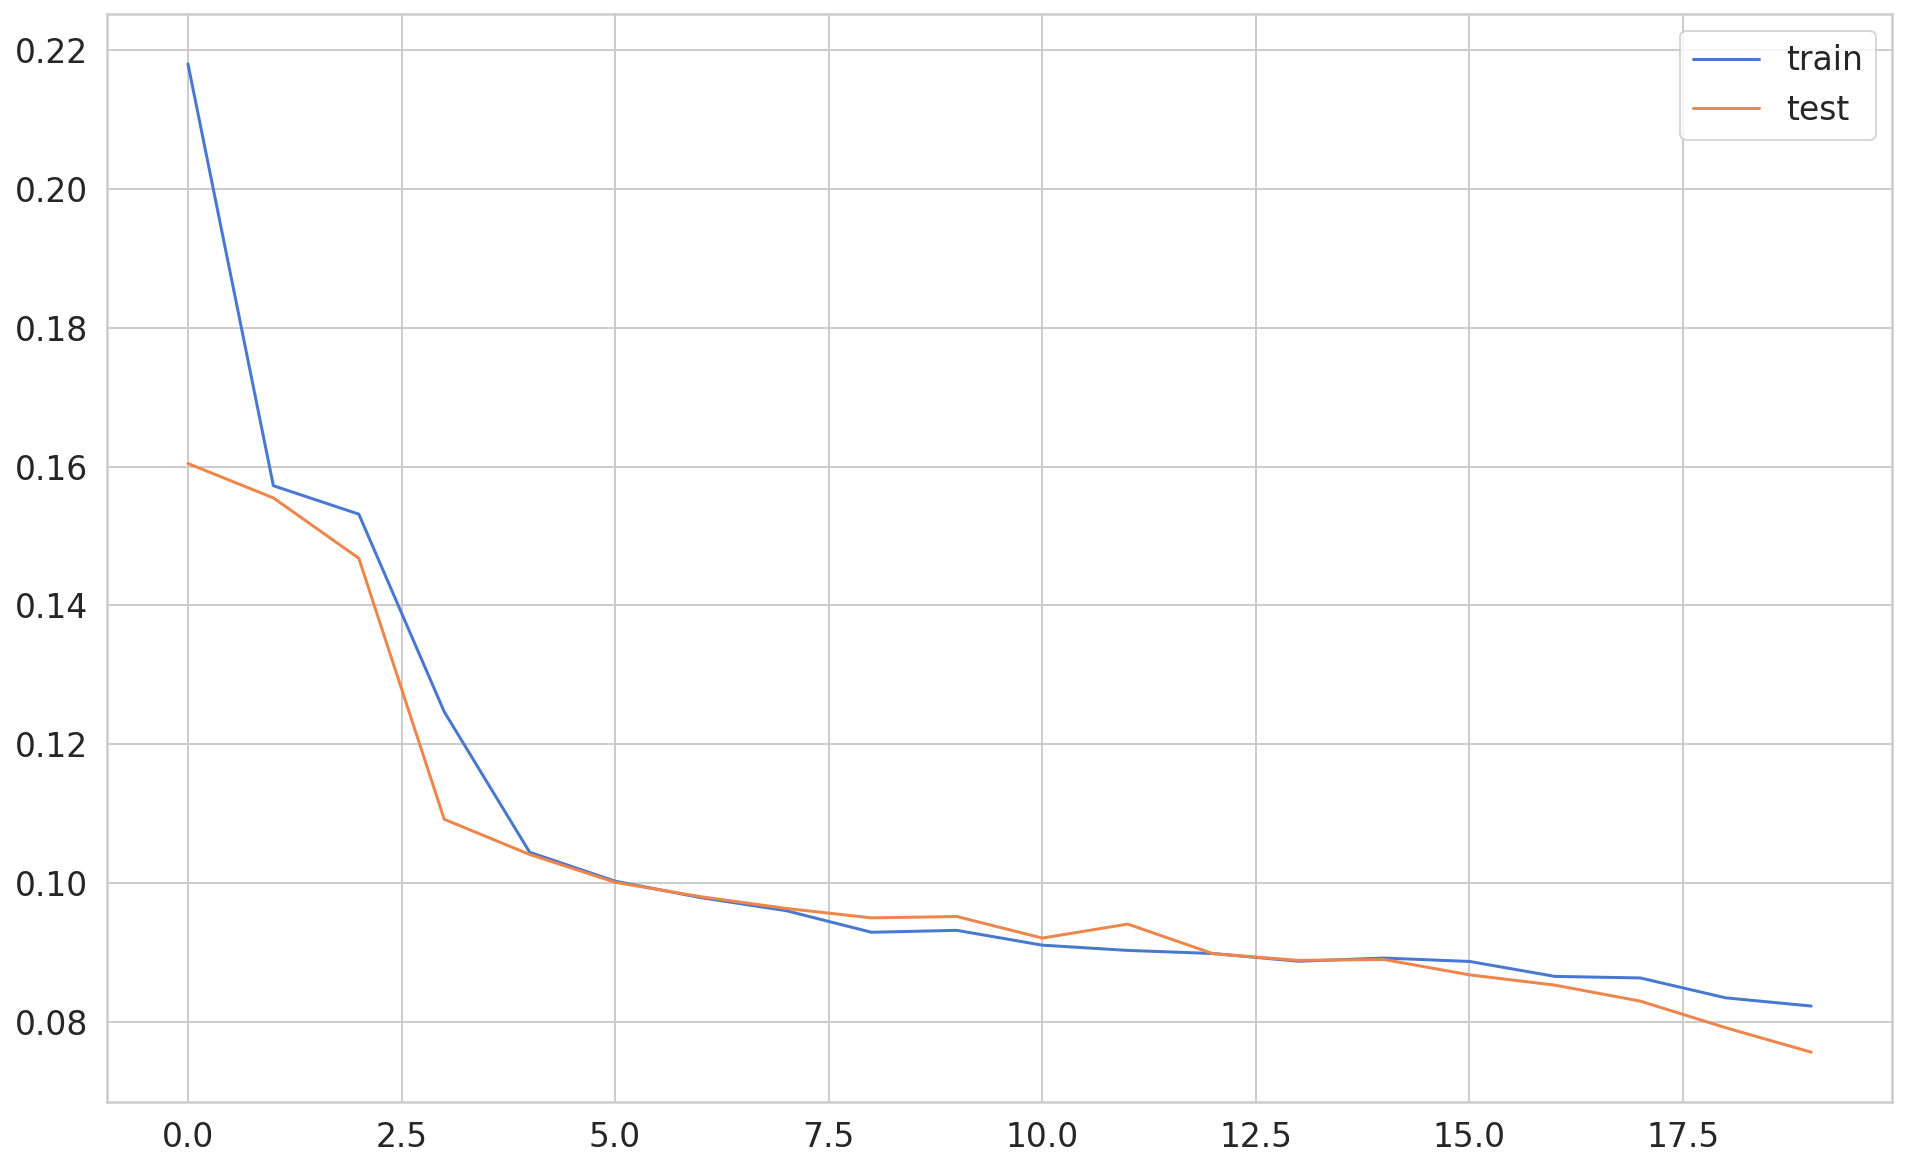

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [48]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

y_test = np.reshape(y_test, (y_test.shape[0], n_steps_out))
y_test.shape

y_train = np.reshape(y_train, (y_train.shape[0], n_steps_out))
y_train.shape

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [49]:
# y_pred

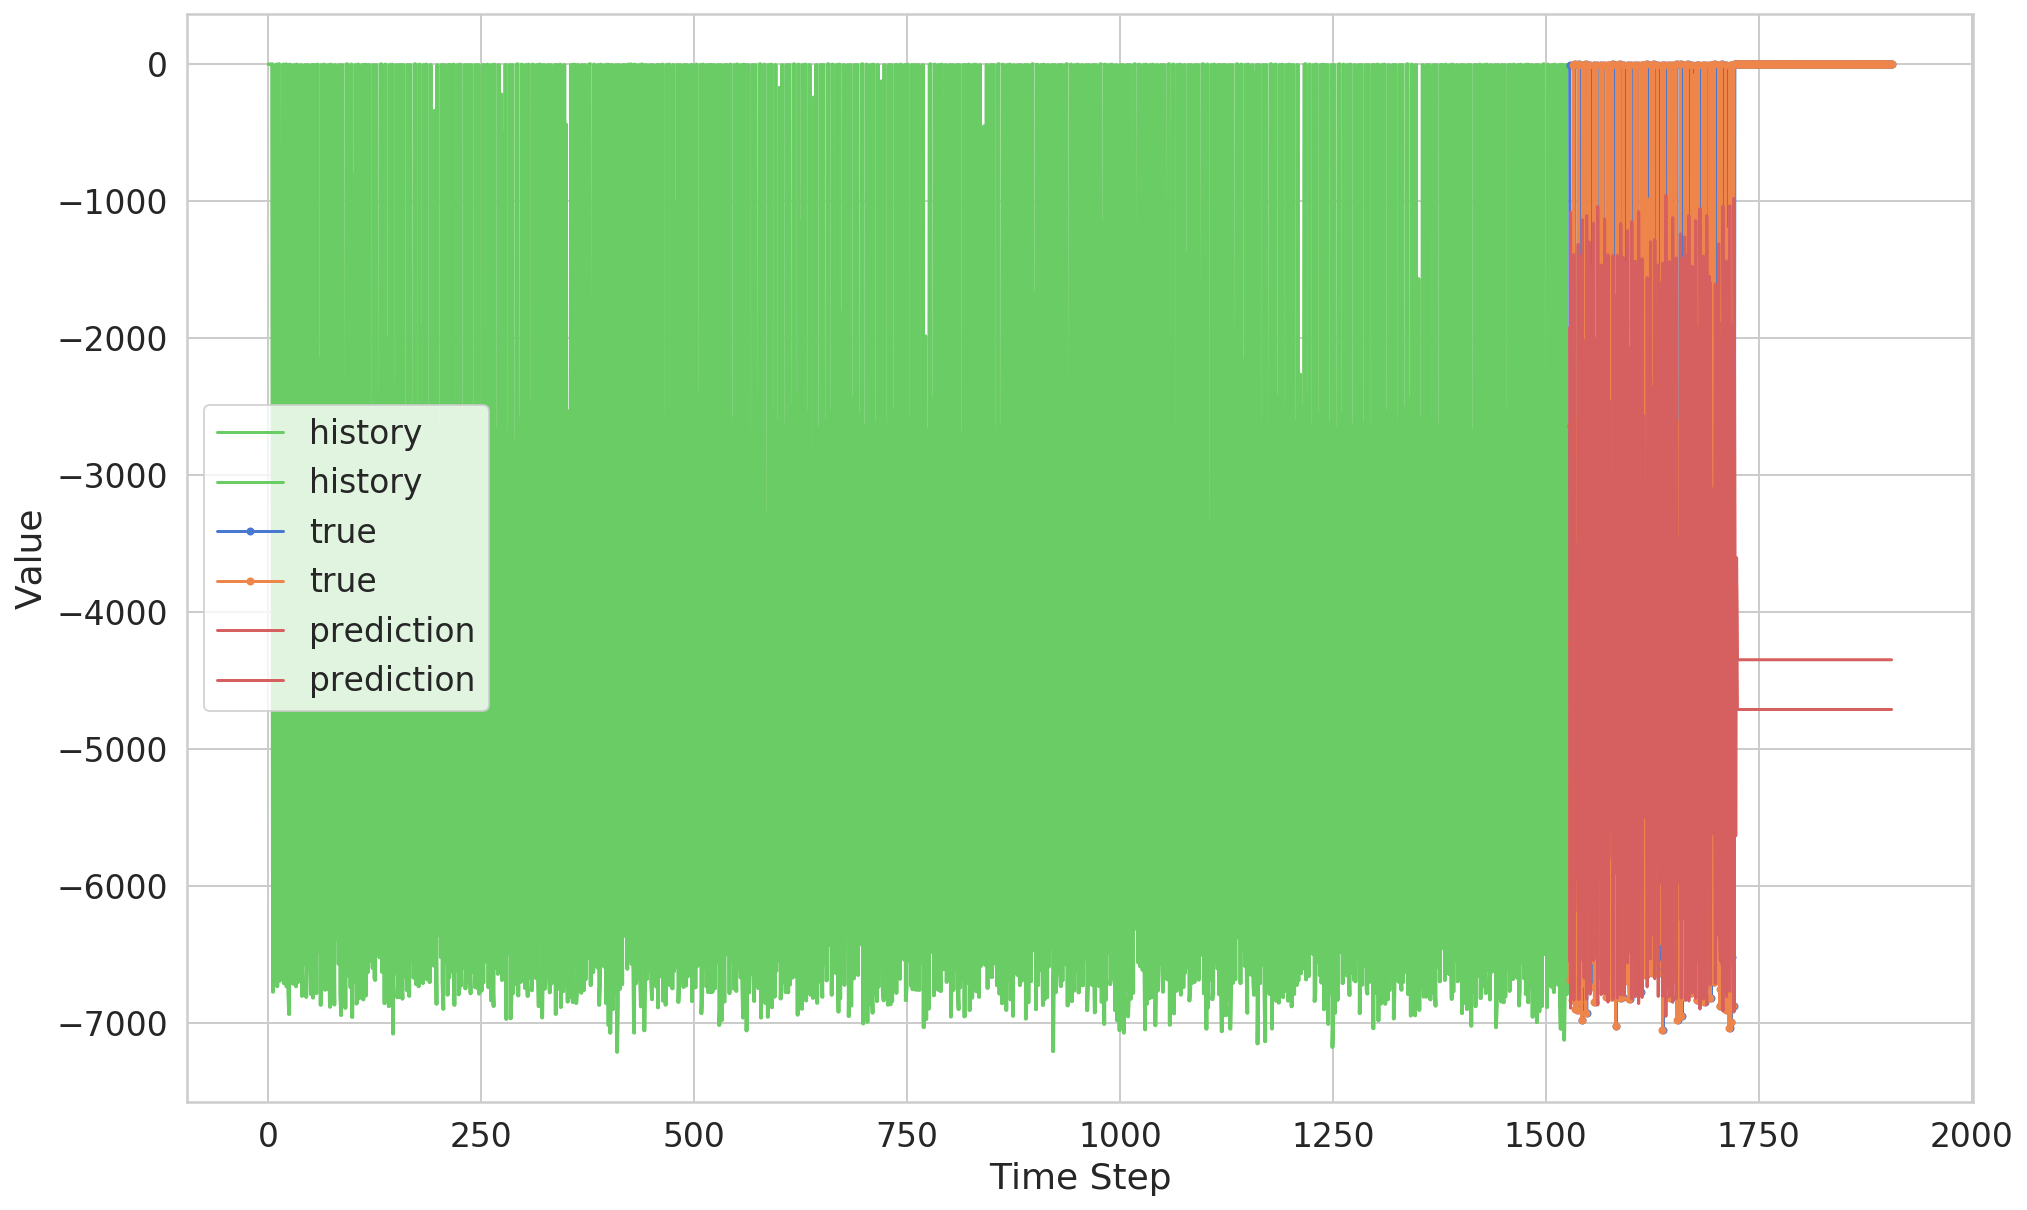

In [50]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

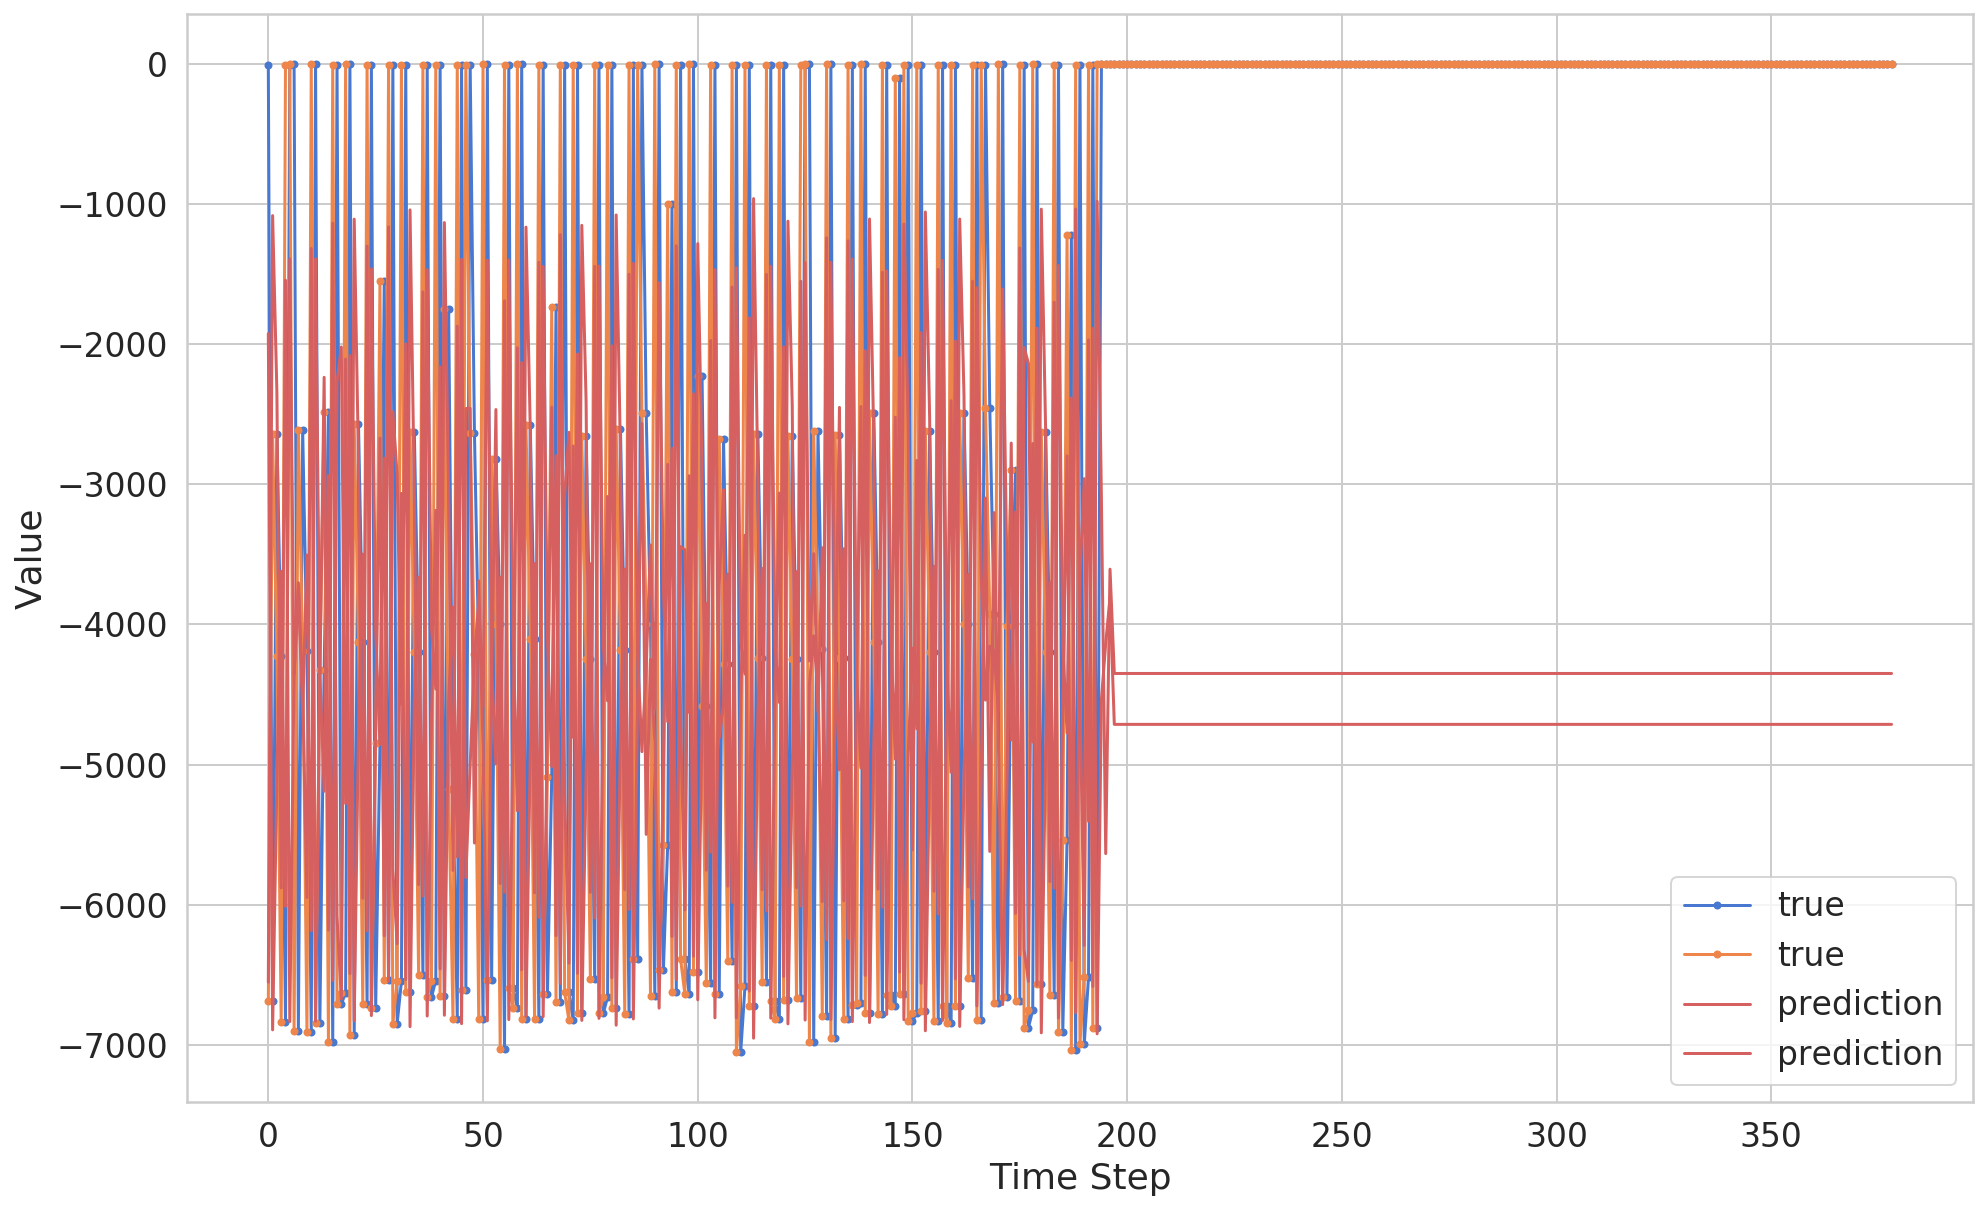

In [51]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Save and Load Model

In [52]:
scores = model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("model.h5")

print(scores)
model.summary()

12342902.473704087
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None,

In [53]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

# summarize model.
# model.summary()

# load dataset
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)

12342902.473704087


# Iterative Training

In [54]:
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

start_time = time.time()
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1
)

print("Time taken: ", time.time()-start_time)


Train on 1375 samples, validate on 153 samples
Epoch 1/5
1375/1375 [==============================] - 4s 3ms/sample - loss: 24164273.2335 - val_loss: 24410693.1373
Epoch 2/5
1375/1375 [==============================] - 1s 876us/sample - loss: 24068741.1665 - val_loss: 24343411.9477
Epoch 3/5
1375/1375 [==============================] - 1s 817us/sample - loss: 24012917.7789 - val_loss: 24295076.9281
Epoch 4/5
1375/1375 [==============================] - 1s 810us/sample - loss: 23969161.5607 - val_loss: 24255254.5621
Epoch 5/5
1375/1375 [==============================] - 1s 818us/sample - loss: 23930957.3105 - val_loss: 24219929.2157
Time taken:  8.917941808700562
